In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import datetime
import sklearn
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, f1_score, auc

### Data Import and initial cleanup

In [2]:
#import data
sn.set()
data = pd.read_excel(r'C:\Users\nickp\Desktop\data science\income classification.xlsx')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
#column types
data.dtypes

age                 int64
 workclass         object
 fnlwgt             int64
 education         object
 education-num      int64
 marital-status    object
 occupation        object
 relationship      object
 race              object
 sex               object
 capital-gain       int64
 capital-loss       int64
 hours-per-week     int64
 native-country    object
 income            object
dtype: object

In [4]:
#remove trailing and leading whitespaces
data = data.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
#remove whitespaces from column names
data.columns = [col.strip() for col in data.columns]

In [5]:
#import country mappings and covert to dictionary to map to data dataframe
country_mappings=pd.read_excel(r'C:\Users\nickp\Desktop\data science\income classification.xlsx', sheet_name='Sheet1')
country_mappings = dict(zip(country_mappings['original country'], country_mappings['region']))
data['Region'] = data['native-country'].map(country_mappings)

In [6]:
#consistent casing
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.lower()
    else:
        pass

### Data Exploration

In [7]:
#count for y variable
data['income'].value_counts()

<=50k    23068
>50k      7650
Name: income, dtype: int64

In [8]:
#check for nulls
def check_nulls(df):
    return df.isnull().sum()

check_nulls(data)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
Region            0
dtype: int64

In [9]:
#summary stats
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30718.000000,3.071800e+04,30718.000000,30718.000000,30718.000000,30718.000000
mean,38.443584,1.898430e+05,10.130314,1106.037079,88.910216,40.949313
std,13.118227,1.054619e+05,2.562469,7497.863364,405.657203,11.985382
min,17.000000,0.000000e+00,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178285e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.785170e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.373170e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [10]:
#function to check unique values in a column
def unique_values(df, column1):
    return df[column1].unique()

unique_values(data, 'occupation')

array(['adm-clerical', 'exec-managerial', 'handlers-cleaners',
       'prof-specialty', 'other-service', 'sales', 'craft-repair',
       'transport-moving', 'farming-fishing', 'machine-op-inspct',
       'tech-support', 'protective-serv', 'armed-forces',
       'priv-house-serv'], dtype=object)

In [11]:
#check unique values in workclass column
unique_values(data, 'workclass')

array(['state-gov', 'self-emp-not-inc', 'private', 'federal-gov',
       'local-gov', 'self-emp-inc', 'without-pay'], dtype=object)

In [12]:
#Dictionary of education grouping
education_groups = {'preschool': 'Less than High School',
                   '1st-4th': 'Less than High School',
                   '5th-6th': 'Less than High School',
                   '7th-8th': 'Less than High School',
                   '9th': 'Less than High School',
                   '10th': 'Less than High School',
                   '11th': 'Less than High School',
                   '12th': 'Less than High School',
                   'prof-school': 'Professional School',
                   'hs-grad': 'High School',
                   'some-college': 'Some College',
                   'assoc-acdm':'Associates Degree - Academic',
                   'assoc-voc': 'Associates Degree - Vocational',
                   'bachelors': 'Bachelors',
                   'masters': 'Masters',
                   'doctorate': 'Doctorate'}

#map education dictionary
data['Education Grouped'] = data['education'].map(education_groups)

In [13]:
#define function to groupby income and variable to get percentage in target variable
def groupby_percents(df, column1, column2, column3, class_count, total_column, percent_column):
    groupby_classes = df.groupby([column1, column2])[column3].count().reset_index()
    groupby_classes.rename(columns={column3:class_count}, inplace=True)
    columns_total_count = df.groupby(column2)[column3].count().reset_index()
    columns_total_count.rename(columns={column3:total_column}, inplace=True)
    groupby_classes = pd.merge(groupby_classes, columns_total_count, on=column2, how='inner')
    groupby_classes[percent_column] = groupby_classes[class_count]/groupby_classes[total_column]
    return groupby_classes

groupby_income_class = groupby_percents(data, 'income', 'Education Grouped', 'race', 'Class Count', 'count of total', 'Percent of Total')
groupby_income_class

,income,Education Grouped,Class Count,count of total,Percent of Total
0,<=50k,Associates Degree - Academic,761,1020,0.746078
1,>50k,Associates Degree - Academic,259,1020,0.253922
2,<=50k,Associates Degree - Vocational,973,1321,0.736563
3,>50k,Associates Degree - Vocational,348,1321,0.263437
4,<=50k,Bachelors,3006,5182,0.580085
5,>50k,Bachelors,2176,5182,0.419915
6,<=50k,Doctorate,103,398,0.258794
7,>50k,Doctorate,295,398,0.741206
8,<=50k,High School,8339,9968,0.836577
9,>50k,High School,1629,9968,0.163423


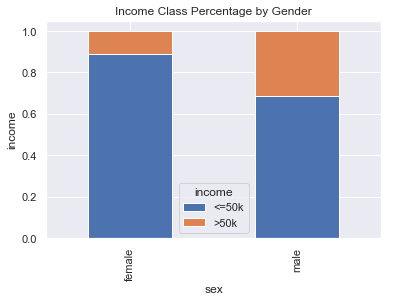

In [14]:
#function to create stacked bar charts of income class composition by variable
def stacked_bar_charts(df, column1, y_column, title):
    table=pd.crosstab(df[column1],df[y_column])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.title("Income Class Percentage by {}".format(title))
    plt.xlabel(column1)
    plt.ylabel(y_column)
    return plt.show()

stacked_bar_charts(data, 'sex', 'income', 'Gender')

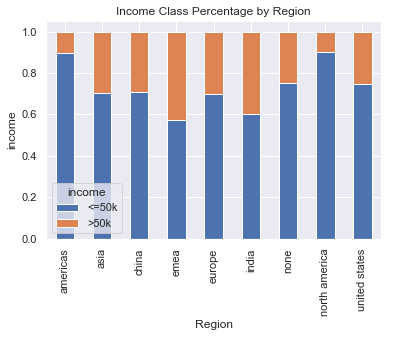

In [15]:
#Stacked bar chart of regions
stacked_bar_charts(data, 'Region', 'income', 'Region')

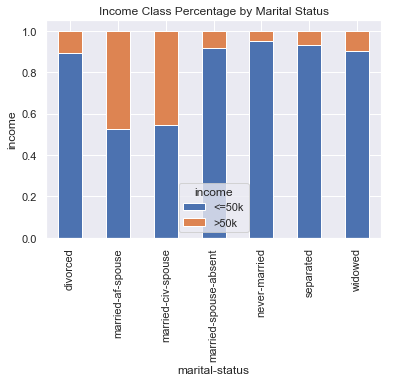

In [16]:
#stacked bar chart by martial status
stacked_bar_charts(data, 'marital-status', 'income', 'Marital Status')

In [17]:
#create a dictionary to group like marital statuses together based on stacked bar chart above
marital_status_dict = {'never-married': 'Never Married',
                      'married-civ-spouse': 'Married',
                      'divorced':'Divorced',
                      'married-spouse-absent':'Separated',
                      'separated':'Separated',
                      'married-af-spouse':'Married',
                      'widowed':'Widowed'}

#map marital status dictionary
data['Marital Status Grouping'] = data['marital-status'].map(marital_status_dict)

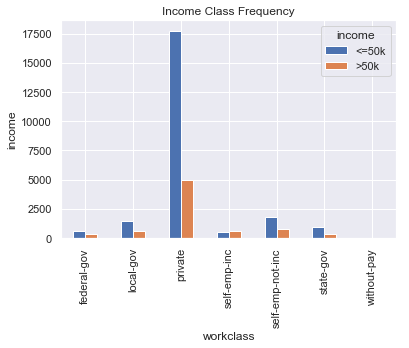

In [18]:
#bar charts with income class frequency
def bar_charts(df, column1, y_variable):
    pd.crosstab(df[column1],df[y_variable]).plot(kind='bar')
    plt.title('Income Class Frequency')
    plt.xlabel(column1)
    plt.ylabel(y_variable)
    return plt.show()

bar_charts(data, 'workclass', 'income')

(array([4932., 5686., 5890., 6056., 3862., 2453., 1304.,  363.,  116.,
          56.]),
 array([17. , 24.3, 31.6, 38.9, 46.2, 53.5, 60.8, 68.1, 75.4, 82.7, 90. ]),
 <a list of 10 Patch objects>)

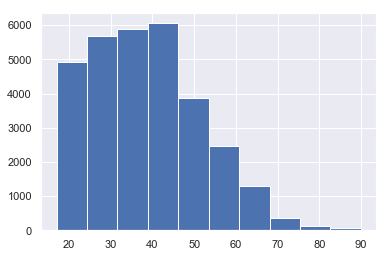

In [19]:
#histogram of age
plt.hist(data['age'])

In [20]:
include_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
#Correlation matrix
def corrmatrix(df, columns):
    df = df[columns]
    corrMatrix = df.corr().reset_index()
    return corrMatrix

corrmatrix(data, include_columns)

,index,age,capital-gain,capital-loss,hours-per-week
0,age,1.000000,0.080392,0.060409,0.101879
1,capital-gain,0.080392,1.000000,-0.032332,0.079548
2,capital-loss,0.060409,-0.032332,1.000000,0.053961
3,hours-per-week,0.101879,0.079548,0.053961,1.000000


### Model Prep and Fitting

In [21]:
#create dictionary to transform target variable to binary
target_variable_mapping = {'>50k': 1,
                          '<=50k': 0}

#map dictionary to new column
data['Target Variable'] = data['income'].map(target_variable_mapping)

#drop fnlwgt column as no description was given for it
data.drop('fnlwgt', axis=1, inplace=True)

In [22]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,Region,Education Grouped,Marital Status Grouping,Target Variable
0,39,state-gov,bachelors,13,never-married,adm-clerical,not-in-family,white,male,2174,0,40,united-states,<=50k,united states,Bachelors,Never Married,0
1,50,self-emp-not-inc,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,0,0,13,united-states,<=50k,united states,Bachelors,Married,0
2,38,private,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,0,0,40,united-states,<=50k,united states,High School,Divorced,0
3,53,private,11th,7,married-civ-spouse,handlers-cleaners,husband,black,male,0,0,40,united-states,<=50k,united states,Less than High School,Married,0
4,28,private,bachelors,13,married-civ-spouse,prof-specialty,wife,black,female,0,0,40,cuba,<=50k,americas,Bachelors,Married,0


In [23]:
#define y variable
y_column = 'Target Variable'

#define x variables
x_variables = ['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain','capital-loss','Region','hours-per-week','Education Grouped','Marital Status Grouping']

#list of categorical variables
cat_columns = ['workclass', 'occupation','race','sex', 'Education Grouped', 'Region', 'Marital Status Grouping']

In [24]:
#split training and test data
def train_test(df, y_var, x_vars, categoricals):
    x = df[x_vars]
    y = df[y_var]
    y = y.ravel()
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=5, test_size=.3, shuffle=True)
    x_test_orig = x_test.copy()
    x_train = pd.get_dummies(x_train, columns=categoricals)
    x_test = pd.get_dummies(x_test, columns=categoricals)
    return x_train, x_test, y_train, y_test, x_test_orig

x_train, x_test, y_train, y_test, x_test_orig = train_test(data, y_column, x_variables, cat_columns)

In [25]:
#create randomforestclassifier and run with default settings
clf=RandomForestClassifier(random_state=10)
clf.fit(x_train, y_train)

C:\Users\nickp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [26]:
#Get Most important features
feature_importance = pd.DataFrame(clf.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 
                                                                        ascending=False)
feature_importance.round(4)

,importance
age,0.2340
Marital Status Grouping_Married,0.1312
hours-per-week,0.1108
capital-gain,0.1084
capital-loss,0.0334
Education Grouped_Bachelors,0.0265
occupation_exec-managerial,0.0264
occupation_prof-specialty,0.0246
Marital Status Grouping_Never Married,0.0238
Education Grouped_Less than High School,0.0189


In [27]:
y_test = pd.DataFrame(y_test)
y_test.rename(columns={0:'Actual'}, inplace=True)

#generate predictions
def get_predictions(x, model, column_name):
    preds = model.predict(x)
    preds = pd.DataFrame(preds)
    preds.rename(columns={0:column_name}, inplace=True)
    return preds

base_model_predictions = get_predictions(x_test, clf, 'Base Model Predictions')

In [28]:
#Calculate and print metrics for default model
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, recall, precision, f1, roc_auc

base_model_accuracy, base_model_recall, base_model_precision, base_model_f1, base_model_roc_auc = metrics(y_test, base_model_predictions)

print("Accuracy: {}".format(base_model_accuracy))
print("Recall: {}".format(base_model_recall))
print("Precision: {}".format(base_model_precision))
print("f1 score: {}".format(base_model_f1))
print("roc auc score: {}".format(base_model_roc_auc))

Accuracy: 0.8428819444444444
Recall: 0.6111111111111112
Precision: 0.7100409836065574
f1 score: 0.6568720379146921
roc auc score: 0.7648244099021302


In [29]:
#Function to show confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion Matrix'):
    
    ax= plt.subplot()
    sn.heatmap(cm, annot=True, ax = ax, fmt='d', cmap='Oranges'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Less than 50k', 'Greater than 50k']); ax.yaxis.set_ticklabels(['Less than 50k', 'Greater than 50k']);

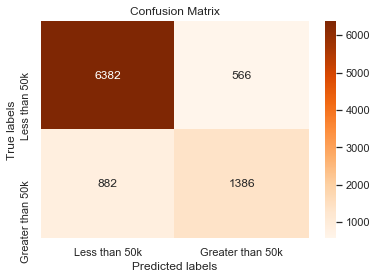

In [30]:
#Show Confusion Matrix for base model
cm_base_model = confusion_matrix(y_test, base_model_predictions)
plot_confusion_matrix(cm_base_model)

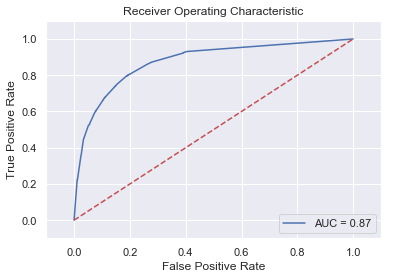

In [31]:
#define roc auc curve plot function
def get_roc_auc_curve(model, x, y_true):
    probs = model.predict_proba(x)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc_proba = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_proba)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-.1, 1.1])
    plt.ylim([-.1, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

get_roc_auc_curve(clf, x_test, y_test)

### Model Tuning

In [32]:
#define parameter grid to do randomizedsearchcv
param_grid = { 
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10, 15, 100],
    'max_depth' : [1,2,5,10,25,50,100,None],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [True,False]
}

#perform randomsearch
rfc = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=100, scoring='roc_auc', cv= 5, random_state=2)

#set datatime to time how long search takes
d1 = datetime.datetime.now()

#fit randomsearch model
rfc.fit(x_train, y_train)

#get time after run and print runtime
d2 = datetime.datetime.now()
elapsedtime = d2-d1
runtime = elapsedtime / datetime.timedelta(minutes=1)
print(f"{runtime: .2f}")

 55.80


In [33]:
#Get best parameters
rfc.best_params_

{'n_estimators': 500,
 'min_samples_split': 100,
 'max_features': 'sqrt',
 'max_depth': 25,
 'criterion': 'entropy',
 'bootstrap': False}

In [34]:
#Get Predictions after tuning model
tuned_model_predictions = get_predictions(x_test, rfc, 'Tuned Model Predictions')

In [35]:
#Calculate and print metrics for tuned model
tuned_model_accuracy, tuned_model_recall, tuned_model_precision, tuned_model_f1, tuned_model_roc_auc_score = metrics(y_test, tuned_model_predictions)

print("Tuned Model Accuracy: {}".format(tuned_model_accuracy))
print("Tuned Model Recall: {}".format(tuned_model_recall))
print("Tuned Model Precision: {}".format(tuned_model_precision))
print("Tuned Model f1 Score: {}".format(tuned_model_f1))
print("Tuned Model ROC AUC Score: {}".format(tuned_model_roc_auc_score))

Tuned Model Accuracy: 0.8597005208333334
Tuned Model Recall: 0.609347442680776
Tuned Model Precision: 0.7724986025712689
Tuned Model f1 Score: 0.6812915947744639
Tuned Model ROC AUC Score: 0.7753847173104513


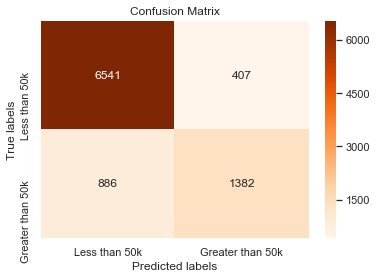

In [36]:
#Confusion Matrix for tuned model
cm_tuned_model = confusion_matrix(y_test, tuned_model_predictions)
plot_confusion_matrix(cm_tuned_model)

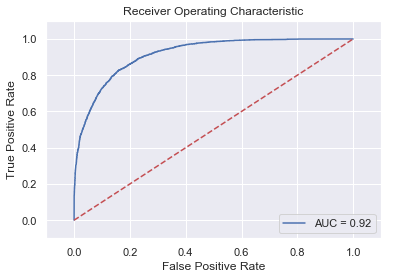

In [37]:
#Plot ROC Curve for Tuned Model
get_roc_auc_curve(rfc, x_test, y_test)

In [38]:
column_list = []
accuracy_list = []
category_list = []
roc_list = []
#Merge test data and predictions for tuned model
x_test_orig = x_test_orig.reset_index()
dataframes = [x_test_orig, y_test, tuned_model_predictions]
df = reduce(lambda left,right: pd.merge(left, right, 
                                              left_index=True, right_index=True, 
                                              how='left'), dataframes)

#list of columns to run metrics by category
columns_for_performance = ['Education Grouped', 'Marital Status Grouping', 'Region', 'race', 'sex']

#calculate metrics for each category in specified columns
for column in columns_for_performance:
    for item in df[column].unique():
        df2 = df.loc[df[column] == item]
        scoring_dataframe = df2[['Actual', 'Tuned Model Predictions']]
        accuracy_by_group = accuracy_score(scoring_dataframe['Actual'], scoring_dataframe['Tuned Model Predictions'])
        roc_auc_score_by_group = roc_auc_score(scoring_dataframe['Actual'], scoring_dataframe['Tuned Model Predictions'])
        column_list.append(column)
        category_list.append(item)
        accuracy_list.append(accuracy_by_group)
        roc_list.append(roc_auc_score_by_group)
        
#convert lists to dataframes and merge
variable = pd.DataFrame({'Variable': column_list})
category = pd.DataFrame({'Category':category_list})
accuracy_group = pd.DataFrame({'Accuracy':accuracy_list})
roc = pd.DataFrame({'ROC AUC Score':roc_list})

scores_columns = [variable, category, accuracy_group, roc]
Scores_by_Categorical_Variables = reduce(lambda left,right: pd.merge(left, right, 
                                              left_index=True, right_index=True, 
                                              how='left'), scores_columns)

Scores_by_Categorical_Variables.sort_values(by=['Variable', 'ROC AUC Score'])

,Variable,Category,Accuracy,ROC AUC Score
3,Education Grouped,Less than High School,0.953901,0.595836
0,Education Grouped,High School,0.869695,0.652138
5,Education Grouped,Doctorate,0.780488,0.653673
1,Education Grouped,Some College,0.859744,0.713983
7,Education Grouped,Associates Degree - Academic,0.834808,0.720817
4,Education Grouped,Associates Degree - Vocational,0.843085,0.740072
6,Education Grouped,Masters,0.791829,0.786813
8,Education Grouped,Professional School,0.832258,0.797283
2,Education Grouped,Bachelors,0.812133,0.813368
12,Marital Status Grouping,Widowed,0.911504,0.600000
